In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import glob as gb
import cv2
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import RMSprop
from pathlib import Path

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Reading data from Google Drive**

In [3]:
with tf.device('/device:GPU:1'):
  flower = []
  features = []
  labels = []
  directory = Path('/content/drive/MyDrive/flowers')
  for dir in directory.iterdir():
    flower.append(dir.name)
    print(dir.name)
    for imgpath in dir.iterdir():
      if imgpath.name.endswith('jpg'):
        labels.append(dir.name)
        imgarr = cv2.imread(str(imgpath),cv2.IMREAD_GRAYSCALE)
        imgarr = cv2.resize(imgarr,(150,150))
        features.append(imgarr)

daisy
rose
sunflower
dandelion
tulip


In [4]:
np.array(features).shape

(4348, 150, 150)

Shuffling Data and Labels with Seed

In [5]:
seed = np.random.randint(100)
np.random.seed(seed)
np.random.shuffle(features)
np.random.seed(seed)
np.random.shuffle(labels)

# **For One Hot Encode processing Data**

In [6]:
all_labels = pd.Series(labels)
all_labels.unique()
all_labels_cat = all_labels.astype('category')
all_labels_cat

0           tulip
1       sunflower
2            rose
3            rose
4       sunflower
          ...    
4343    dandelion
4344    sunflower
4345    dandelion
4346         rose
4347        tulip
Length: 4348, dtype: category
Categories (5, object): ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [7]:
all_labels_cat = all_labels.astype('category').cat.codes
print(all_labels_cat.head())
from keras.utils.np_utils import to_categorical
allEncodedLabels = to_categorical(all_labels_cat)
len(allEncodedLabels)

0    4
1    3
2    2
3    2
4    3
dtype: int8


4348

# **Dividing data in Training,validation and Testind datasets**

In [8]:
data_len = len(features)
train_data = features[:data_len*50//100]
val_data = features[data_len*50//100:data_len*70//100]
test_data = features[data_len*70//100:]
labels_len = len(allEncodedLabels)
train_labels = allEncodedLabels[:labels_len*50//100]
val_labels = allEncodedLabels[labels_len*50//100:labels_len*70//100]
test_labels = allEncodedLabels[labels_len*70//100:]

In [9]:
train_data = np.array(train_data)
val_data = np.array(val_data)
test_data = np.array(test_data)
# tarin_data = np.array(train_data)
# tarin_data = np.array(train_data)
# tarin_data = np.array(train_data)

# **ReShapeing and Normalizing data**

In [11]:
train_data = train_data.reshape((2174,150*150))
val_data = val_data.reshape((869,150*150))
test_data = test_data.reshape((1305,150*150))
train_data = train_data.astype("float32")/255
val_data = val_data.astype("float32")/255
test_data = test_data.astype("float32")/255

# **Preparing Model with Relu as activation function**

In [12]:
from keras import models
from keras import layers
network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(150*150,)))
network.add(layers.Dense(256, activation='relu'))
network.add(layers.Dense(5, activation='softmax'))

In [13]:
network.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy'])

In [14]:
with tf.device('/device:GPU:1'):
  model = network.fit(train_data, train_labels, epochs=100, batch_size=256,validation_data=(val_data,val_labels))

Epoch 1/100
9/9 [==============================] - 4s 377ms/step - loss: 50.3422 - accuracy: 0.2213 - val_loss: 16.3283 - val_accuracy: 0.1726
Epoch 2/100
9/9 [==============================] - 3s 344ms/step - loss: 12.9618 - accuracy: 0.1927 - val_loss: 10.2150 - val_accuracy: 0.2198
Epoch 3/100
9/9 [==============================] - 3s 345ms/step - loss: 7.0611 - accuracy: 0.2272 - val_loss: 5.1059 - val_accuracy: 0.2451
Epoch 4/100
9/9 [==============================] - 3s 352ms/step - loss: 5.9352 - accuracy: 0.2390 - val_loss: 3.4204 - val_accuracy: 0.2463
Epoch 5/100
9/9 [==============================] - 3s 350ms/step - loss: 4.2422 - accuracy: 0.2364 - val_loss: 3.8766 - val_accuracy: 0.1876
Epoch 6/100
9/9 [==============================] - 3s 347ms/step - loss: 4.1704 - accuracy: 0.2162 - val_loss: 1.7846 - val_accuracy: 0.2428
Epoch 7/100
9/9 [==============================] - 3s 344ms/step - loss: 2.1680 - accuracy: 0.2306 - val_loss: 2.6554 - val_accuracy: 0.2244
Epoch 8/1

In [15]:
dict_hist = model.history
accuracy = dict_hist['accuracy']
Val_accuracy = dict_hist['val_accuracy']
Val_loss = dict_hist['val_loss']
loss = dict_hist['loss']

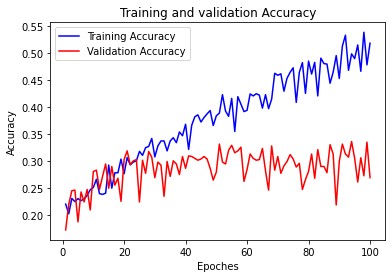

In [16]:
epoches = np.arange(1,len(dict_hist['accuracy'])+1)
plt.plot(epoches,accuracy,'b',label="Training Accuracy")
plt.plot(epoches,Val_accuracy,'r',label="Validation Accuracy")
plt.title('Training and validation Accuracy')
plt.xlabel("Epoches")
plt.ylabel("Accuracy")
plt.legend()
# plt.show()

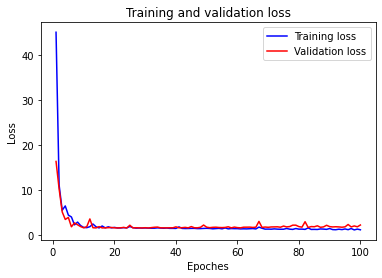

In [17]:
epoches = np.arange(1,len(dict_hist['accuracy']) + 1)
plt.plot(epoches,loss,'b',label="Training loss")
plt.plot(epoches,Val_loss,'r',label="Validation loss")
plt.title('Training and validation loss')
plt.xlabel("Epoches")
plt.ylabel("Loss")
plt.legend()
# plt.show()

# **Evaluation Step**

In [18]:
test_loss, test_acc = network.evaluate(val_data, val_labels)

28/28 [==============================] - 1s 23ms/step - loss: 2.1879 - accuracy: 0.2693


# **Prediction**

In [24]:
predictions = network.predict(test_data)

In [33]:
y_p = predictions.flatten()
y_t = test_labels.flatten()

In [34]:
tf.math.confusion_matrix(
    y_p, y_t, num_classes=None, weights=None, dtype=tf.dtypes.int32,
    name=None
)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[5220, 1305],
       [   0,    0]], dtype=int32)>